In [13]:
from datasets import load_dataset
from evaluate import evaluator
import torch
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
import numpy as np
import torch.nn.functional as F
from datasets import load_metric
import wandb
import os
import scipy
from transformers.utils.logging import set_verbosity_error
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
class TrainDataset(Dataset):
  def __init__(self, filename=None, df=None, tokenizer=None):
    super().__init__()
    if filename:
      self.df = pd.read_csv(filename, sep="\t")
    else:
      self.df = df
    self.encoding = tokenizer(self.df["text"].values.tolist(), truncation=True, padding=True, return_tensors="pt")
  def __len__(self):
    return len(self.df)
  def __getitem__(self, index):
    label = 1 if self.df["label"].iloc[index] == "MOS" else 0
    return {"input_ids": self.encoding["input_ids"][index], "attention_mask" : self.encoding["attention_mask"][index], "label" : label}
  def getlabels(self):
    return np.array([1 if label == "MOS" else 0 for label in self.df["label"].values])
  def getDataFrame(self):
    return self.df

class TestDataset(Dataset):
  def __init__(self, filename=None, df=None, tokenizer=None):
    super().__init__()
    if filename:
      self.df = pd.read_csv(filename, sep="\t")
    else:
      self.df = df
    self.encoding = tokenizer(self.df["text"].values.tolist(), truncation=True, padding=True, return_tensors="pt")
  def __len__(self):
    return len(self.df)
  def __getitem__(self, index):
    return {"input_ids": self.encoding["input_ids"][index], "attention_mask" : self.encoding["attention_mask"][index]}
  def getlabels(self):
    return np.array([1 if label == "MOS" else 0 for label in self.df["label"].values])
  def getDataFrame(self):
    return self.df

In [4]:
def compute_metrics_fn(eval_preds):
        metrics_data = dict()
        
        accuracy_metric = load_metric('accuracy')
        precision_metric = load_metric('precision')
        recall_metric = load_metric('recall')
        f1_metric = load_metric('f1')


        logits = eval_preds.predictions
        labels = eval_preds.label_ids
        preds = np.argmax(logits, axis=-1)  
        
        metrics_data.update(accuracy_metric.compute(predictions=preds, references=labels))
        metrics_data.update(precision_metric.compute(predictions=preds, references=labels))
        metrics_data.update(recall_metric.compute(predictions=preds, references=labels))
        metrics_data.update(f1_metric.compute(predictions=preds, references=labels))
        return metrics_data

In [6]:
def compute_interval(measure, n):
    confidence_level = 0.95
    z_score = -1 * scipy.stats.norm.ppf((1-confidence_level)/2)
    standard_error = np.sqrt(measure * (1-measure) / n)
    return z_score*standard_error
def print_detail(eval, n):
    print("Accuracy:", eval["eval_accuracy"], "+/-", compute_interval(eval["eval_accuracy"], n) )
    print("Recall:", eval["eval_recall"], "+/-", compute_interval(eval["eval_recall"], n) )
    print("Precision:", eval["eval_precision"], "+/-", compute_interval(eval["eval_precision"], n) )
    print("F1:", eval["eval_f1"], "+/-", compute_interval(eval["eval_f1"], n) )
def get_confusion(ds, trainer):
    y_trues = ds.getlabels()
    predictions = torch.from_numpy(trainer.predict(ds).predictions).float()
    y_preds = torch.argmax(F.softmax(predictions), axis=-1).cpu().detach().numpy()
    confusion_matrix = metrics.confusion_matrix(y_trues, y_preds, labels=[0, 1]) # NMOS, MOS
    df = ds.getDataFrame()
    df["pred"] = y_preds
    df["pred_label"] = df["pred"].apply(lambda x: "MOS" if x == 1 else "NMOS")
    disagree = df[df.label != df.pred_label]
    disagree_group = disagree.groupby("adjudicator_id").count()["label"]
    return confusion_matrix, disagree_group

BERT

In [5]:
model_name = "bert-base-uncased"
def model_init():
        model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2)
        if model_name == "distilgpt2":
            model.config.pad_token_id = model.config.eos_token_id # use this if the model is GPT
        return model

tokenizer = AutoTokenizer.from_pretrained(model_name)
if model_name == "distilgpt2" :
    tokenizer.pad_token = tokenizer.eos_token # use this if the model is GPT

test_ds = TrainDataset("test.tsv", tokenizer=tokenizer)

In [9]:
def evaluate_model(model_name, model_file):
    set_verbosity_error()
    task_evaluator = evaluator("text-classification")
    train_model = AutoModelForSequenceClassification.from_pretrained(model_file)
    trainer = Trainer(model=train_model, compute_metrics=compute_metrics_fn)
    eval = trainer.evaluate(test_ds)
    confusion, disagree_group = get_confusion(test_ds, trainer)
    return eval, confusion, disagree_group

In [ ]:
eval, confusion, disagree_group = evaluate_model("bert-base-uncased", "bert-base-uncased-lr5.315e-05-bs8-ep3-wd0.3")

In [11]:
print_detail(eval, len(test_ds))

Accuracy: 0.86 +/- 0.048089065389731414
Recall: 0.7654320987654321 +/- 0.05872468819664677
Precision: 0.8732394366197183 +/- 0.046109651938954
F1: 0.8157894736842104 +/- 0.05372536361537872


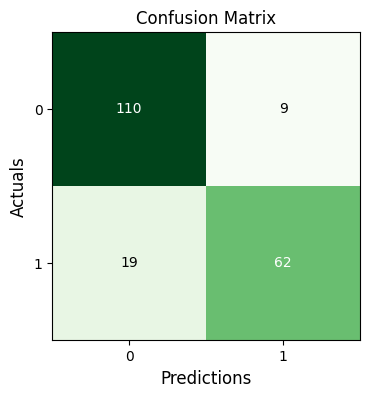

In [15]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(conf_mat=confusion, figsize=(4, 4), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show()

RoBERTa

In [ ]:
model_name = "roberta-base"
def model_init():
        model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2)
        if model_name == "distilgpt2":
            model.config.pad_token_id = model.config.eos_token_id # use this if the model is GPT
        return model

tokenizer = AutoTokenizer.from_pretrained(model_name)
if model_name == "distilgpt2" :
    tokenizer.pad_token = tokenizer.eos_token # use this if the model is GPT

test_ds = TrainDataset("test.tsv", tokenizer=tokenizer)

In [ ]:
eval, confusion, disagree_group = evaluate_model("roberta-base", "roberta-base-lr2.068e-05-bs8-ep3-wd0.2")

In [23]:
print_detail(eval, len(test_ds))

Accuracy: 0.855 +/- 0.04879778977041656
Recall: 0.8148148148148148 +/- 0.05383511828484421
Precision: 0.825 +/- 0.05265978623379108
F1: 0.8198757763975155 +/- 0.053259021327903194


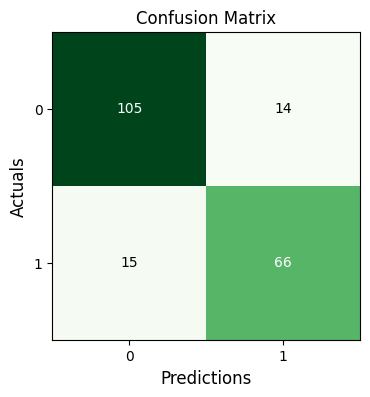

In [24]:
plot_confusion_matrix(conf_mat=confusion, figsize=(4, 4), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show()

DistilGPT2

In [ ]:
model_name = "distilgpt2"
def model_init():
        model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2)
        if model_name == "distilgpt2":
            model.config.pad_token_id = model.config.eos_token_id # use this if the model is GPT
        return model

tokenizer = AutoTokenizer.from_pretrained(model_name)
if model_name == "distilgpt2" :
    tokenizer.pad_token = tokenizer.eos_token # use this if the model is GPT

test_ds = TrainDataset("test.tsv", tokenizer=tokenizer)

In [ ]:
eval, confusion, disagree_group = evaluate_model("distilgpt2", "distilgpt2-lr7.034e-05-bs8-ep4-wd0.4")

In [27]:
print_detail(eval, len(test_ds))

Accuracy: 0.845 +/- 0.05015650850290584
Recall: 0.7654320987654321 +/- 0.05872468819664677
Precision: 0.8378378378378378 +/- 0.05108434640818507
F1: 0.8 +/- 0.055436152973987116


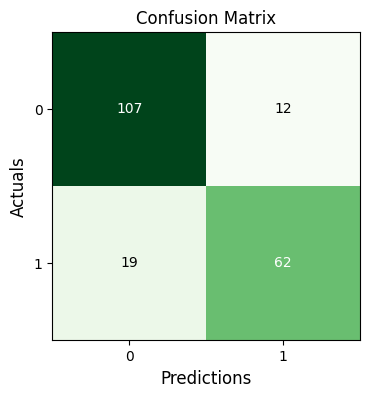

In [28]:
plot_confusion_matrix(conf_mat=confusion, figsize=(4, 4), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show()